# Preprocess dataset

In [27]:
import os
import json
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from open_clip import create_model_and_transforms, get_tokenizer
from open_clip.factory import HF_HUB_PREFIX, _MODEL_CONFIGS
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score
)
from tqdm import tqdm

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

# 1. Paths & constants
METADATA_CSV = "/home/E19_FYP_Domain_Gen_Data/metadata.csv"
PATCHES_DIR  = "/home/E19_FYP_Domain_Gen_Data/patches"
CONFIG_PATH  = "../BioMedClip/checkpoints/open_clip_config.json"
WEIGHTS_PATH = "../BioMedClip/checkpoints/open_clip_pytorch_model.bin"
MODEL_NAME   = "biomedclip_local"
CONTEXT_LENGTH = 256
BATCH_SIZE   = 32
NUM_WORKERS  = 4
DEVICE       = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class BiomedCLIPDataset(Dataset):
    def __init__(self, df, preprocess):
        self.filepaths = df["filepath"].tolist()
        self.labels    = df["tumor"].astype(int).tolist()
        self.preproc   = preprocess

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        img = Image.open(self.filepaths[idx]).convert("RGB")
        img = self.preproc(img)           # yields a torch.Tensor (C,H,W)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return img, label

def append_filename_and_filepath(df):
    df["filename"] = df.apply(
        lambda r: f"patch_patient_{r.patient:03d}_node_{r.node}_x_{r.x_coord}_y_{r.y_coord}.png",
        axis=1
    )
    df["filepath"] = df.apply(
        lambda r: os.path.join(
            PATCHES_DIR,
            f"patient_{r.patient:03d}_node_{r.node}",
            r.filename
        ), 
        axis = 1
    )
    return df

random_state = 42
shots = 16

# 2. Load metadata and filter center=0
metadata_df = pd.read_csv(METADATA_CSV, index_col=0)
metadata_df = append_filename_and_filepath(metadata_df)


# train_df = metadata_df[(metadata_df.center.isin([0, 1, 2])) & (metadata_df.split == 0)].copy()
validation_df = metadata_df[(metadata_df.center == 3) & (metadata_df.split == 1)].copy().sample(n=100, random_state=random_state)
test_df = metadata_df[(metadata_df.center == 4) & (metadata_df.split == 1)].copy()


train_df = pd.concat([
    metadata_df[(metadata_df['tumor'] == 1) & (metadata_df['center'] == 0)].sample(n=shots, random_state=random_state),
    metadata_df[(metadata_df['tumor'] == 0) & (metadata_df['center'] == 0)].sample(n=shots, random_state=random_state),
    # metadata_df[(metadata_df['tumor'] == 1) & (metadata_df['center'] == 1)].sample(n=shots, random_state=random_state),
    # metadata_df[(metadata_df['tumor'] == 0) & (metadata_df['center'] == 1)].sample(n=shots, random_state=random_state),
    # metadata_df[(metadata_df['tumor'] == 1) & (metadata_df['center'] == 2)].sample(n=shots, random_state=random_state),
    # metadata_df[(metadata_df['tumor'] == 0) & (metadata_df['center'] == 2)].sample(n=shots, random_state=random_state),
]).reset_index(drop=True)

# Gemini

In [4]:
from gemini import Gemini
cookies = {"__Secure-1PSIDCC" : "AKEyXzUqZe72U1p0uaLeIZiLYH2ieBn0Nbkz62L6X8E7_NSs6BmFE-eFhQ5GnnrGoHkZzB5bunGp", 
           "__Secure-1PSID" : "g.a000wgh5UnikS3MgaQbBrwOks9wXRHcyaiqgzL7KBndo7ATWBrvTvN6kCDnqXfkOnfemJj4mqwACgYKAUsSARQSFQHGX2MiEu55NtUIn8L5nXEYQqrQXxoVAUF8yKpFS3_FRjjcqH7w1bMYkAeZ0076",
           "__Secure-1PSIDTS": "sidts-CjIBjplskFYe9oKdkDOXlYe4lPhrH7TeDoX4bdIcNCbU2ekSNao7X5VsAopMa5nUxGHFLRAA", 
        #    "NID": "523=FXtMnWFj-uBe_i5IcJgkGpBdqvPI0-AzTr9lxYDbMIqdkHiDtw9gAWkee9tB9e9Rp3Adfj2GqhlXAy8Ssa9f7dbbM9tSs8_ww-kAUFqeZRFDjhz3flcdrKH85NFY6hEp88dTgU8aod07KQFZqy_wVr-fvMgJ6JjUr9fSH6UUTIaIo30UQ7NxJL0YR6nmG23OgcN54dbI01JXtCbPg0QpQ63em4hXJXiPdKo4XBIpld80Sg9odyFGZOjZ_iFjN7-fvaxMkIPqHAoypL_g4S1vNdwGcG7PhyqMDClSNn-kubIsvkWbGTORzDAI2lcGvipfH0VIH-ypsxR7c9N_cmWuzAlX5R8hwsZjf9PsEKYRkKzBK-AE-IWI9R-RQpVIyROzwaWXQgIQS5VrDfllHHfaZw0MvzoG_5otlOCaE08ZlhrI9ZKgb8JKEe0SHRJqPjx4QOQ1U_zAfYMSh0ESVPUj4MfwIg6LvcS53I2sDIxNCWwdiFqicEjphgnjPZUJYHViZ8fQYq4dU7sTOoa1pSSItgpcCfr6ukWKe_2GowpQkSpynKXIPsAzbulmD_DQD9DLaPWz0kYcJOcuiPISDvp2P0yKsn3E8dmjbxvGijDvs5-zeyIkTklsqeCBNT5-qSaeiSGxiKphd9QmeUnJzxS0TxCDediwTVRByKy6_SibIjhleU1ndMGLprEAQsNBTZO4iHci-XyyI8Hlr3OMJhFQqkcyRdDpR-1eZ61nrXt84UwzVAbtNnPaEraWm1oUSY0Cwm19WHlDdF9ykk71o7-ghxdtpiVNIv4r3n_8orMr-_AT_uqcOKGJx9UaGUukyG6XkGwy4Jd4KmD8tV6VKd9eO1PzmVdrllBoN0-DDvA7vEGedvwCidMqQfOJVw0RtqFUyENkudRVjICu1ja2KDW25j3GqBlWh_ju5Vr8uN6vItjgCzS8xStemHUTNH03b6-wK-YzXMhzstThUaPRmfTVVBnBrGbylqRkTAQGf_duZoX1iSCeRg1Jp9pWL22SYEh1g0DTDdMnkNN2IIruhUxQwly5a5-RsbfoY5W9z_N7ldP3Ma39nXt2Ddk17JAavp_6AVEf249fgIK4y3XTMXxxQ_Y4wy6dhXxzzhsf_xbtASwoQItLXdi6BO65kJgP_Sz-t4w5cJNseHgJ-IhJ7_suv-1-4TQ3EUeOlDl1Bb_NnNFt_ch3CDJBV1guezKP7J4Ay4Pyc6KGO5BZiOrTPSBjcNnGLimmg17jaWw3mUF1zAw5QPMIzFzuagTP7YnX_b0MUVpLaui9i0tJY1uX8mk1ArYOAkFx7i8K_DztT2pZxx-TAFkrebM_rbRd8du8Pv0BqMcUEz_XVgTYoVvWcOpfoW_xKSUeRhnPawAaimNw7eaZXJNY7UCs6dzQ__rFE8PXmyMcKP7uXe4sWQ_4JD5oky_lLVq7QzRscgjP6E3b_dgGEzLUrY5uxwYnbiJiFfifs8VgO47uN_j7j_WMWAc8NSwqJvwCeI6nAFfzPjcQveeaMu-TtYQJBRRINI9MgSbFhjF1rbIx6IxHcRivu-nH00WAcmwML0NWNYM4IW9LVeyKi69hFmtjSdBzzbcwy-Htk35N-jCDH8yg9ol7fpK1T9aki1sBer_hrDS3H134lYpeK07Tb97bfI9hZW8f2sv6xC1NhhFIgtHqq9zDAIru8QmWm0d6JNkl9d8q2QOex-QPigh6RndsDbONLV5hsV28Esi9mUpITiIteaLmzrFDXaEfMfgmIio-bAD3BABoKwZxx7EabHqRFTpeg7Z_6txeYQwvBaY4jzgw75vghzkVgRlbfpqUzhoxprM1L9IS-bKHfw", 
           
           } # Cookies may vary by account or region. Consider sending the entire cookie file.


client = Gemini(auto_cookies=False, cookies=cookies)

prompt_template =  ["""Give me 50 textual descriptions pairs of visual discriminative features to identify whether the central region of an histopathological image patch contains tumor tissue or not. The patch is extracted from an H&E‑stained whole‑slide image of a lymph node section.""",
                    """Here are the best performing pairs. You should aim to get higher scores. Each description should be about 5-20 words.
                    1-10: Generate the first 10 pairs exploring variations of the top 1 (best) given. Remove certain words, add words, change order and generate variations.
                    11-20: Generate 10 pairs using the top 10, explore additional knowledge and expand on it. 
                    21-30: The next 10 pairs should maintain similar content as middle pairs but use different language style and sentence structures. 
                    31-40: The next 10 pairs should combine knowledge of top pairs and bottom pairs.
                    41-50: The remaining 10 pairs should be randomly generated. 
                    """, 
                    """Only give the output as python code in the format - prompts: list[tuple[negative: str, positive: str]]"""]

In [6]:
import ast, re, io, tokenize
from typing import List, Tuple

def _force_double_quotes(code: str) -> str:
    """
    Rewrites every Python string-literal in `code` to use double-quotes,
    escaping only backslashes and interior double-quotes.
    """
    tokens = tokenize.generate_tokens(io.StringIO(code).readline)
    new_tokens = []
    for toknum, tokval, start, end, line in tokens:
        if toknum == tokenize.STRING:
            # Evaluate the literal to get its true value
            value = ast.literal_eval(tokval)
            # Wrap in double-quotes and escape interior backslashes and quotes
            safe = value.replace('\\', '\\\\').replace('"', '\\"')
            tokval = f'"{safe}"'
        new_tokens.append((toknum, tokval))
    return tokenize.untokenize(new_tokens)

def get_prompt_pairs(prompt_template: Tuple[str, str], content: str) -> List[Tuple[str, str]]:

    if content == "":
        prompt = prompt_template[0] + "\n" + prompt_template[2]
    else:
        prompt = prompt_template[0] + "\n" + prompt_template[1] + "\n" + content + "\n" + prompt_template[2]
    response = client.generate_content(prompt)
    raw = response.text

    # 1) extract the python block
    m = re.search(r'```python\s*(.*?)\s*```', raw, re.S)
    code = m.group(1) if m else raw

    # 2) normalize all literals to double-quoted form
    code = _force_double_quotes(code)

    # 3) parse and extract
    tree = ast.parse(code)
    prompts_list = None
    for node in tree.body:
        if isinstance(node, ast.Assign) and any(
            isinstance(t, ast.Name) and t.id == 'prompts' for t in node.targets
        ):
            prompts_list = ast.literal_eval(node.value)
            break

    prompts: List[Tuple[str, str]] = prompts_list  # type: ignore
    print(f"Loaded {len(prompts)} prompt-pairs.")
    print("First pair:", prompts[0])
    return prompts


# Evaluating Prompt Pair

In [37]:
# 6. Load BiomedCLIP model + tokenizer + preprocess
with open(CONFIG_PATH, "r") as f:
    cfg = json.load(f)
model_cfg, preproc_cfg = cfg["model_cfg"], cfg["preprocess_cfg"]

# register local config if needed
if (not MODEL_NAME.startswith(HF_HUB_PREFIX)
    and MODEL_NAME not in _MODEL_CONFIGS):
    _MODEL_CONFIGS[MODEL_NAME] = model_cfg

tokenizer = get_tokenizer(MODEL_NAME)
model, _, preprocess = create_model_and_transforms(
    model_name=MODEL_NAME,
    pretrained=WEIGHTS_PATH,
    **{f"image_{k}": v for k,v in preproc_cfg.items()}
)

model = model.to(DEVICE).eval()

# 7. Prepare DataLoader for test set
train_ds = BiomedCLIPDataset(train_df, preprocess)
train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE,
    shuffle=False, num_workers=NUM_WORKERS
)

test_ds = BiomedCLIPDataset(test_df, preprocess)
test_loader = DataLoader(
    test_ds, batch_size=BATCH_SIZE,
    shuffle=False, num_workers=NUM_WORKERS
)

validation_ds = BiomedCLIPDataset(validation_df, preprocess)
validation_loader = DataLoader(
    validation_ds, batch_size=BATCH_SIZE,
    shuffle=False, num_workers=NUM_WORKERS
)

def evaluate_prompt_pair(negative_prompt, positive_prompt, loader):
    text_inputs = tokenizer(
        [negative_prompt, positive_prompt], context_length=CONTEXT_LENGTH
    ).to(DEVICE)

    with torch.no_grad():
        text_feats = model.encode_text(text_inputs)               # (2, D)
        text_feats = text_feats / text_feats.norm(dim=1, keepdim=True)
        logit_scale = model.logit_scale.exp()

        all_preds  = []
        all_probs  = []
        all_labels = []

        # 9. Inference loop
        for imgs, labels in tqdm(loader, desc="Evaluating"):
            imgs   = imgs.to(DEVICE)
            labels = labels.to(DEVICE)

            img_feats = model.encode_image(imgs)                    # (B, D)
            img_feats = img_feats / img_feats.norm(dim=1, keepdim=True)

            logits = logit_scale * (img_feats @ text_feats.t())     # (B, 2)
            probs  = logits.softmax(dim=1)                          # (B, 2)
            preds  = logits.argmax(dim=1)                           # (B,)

            all_preds .append(preds.cpu())
            all_probs .append(probs[:, 0].cpu())  # tumor-class prob
            all_labels.append(labels.cpu())

        # concatenate
        y_pred = torch.cat(all_preds).numpy()
        y_prob = torch.cat(all_probs).numpy()
        y_true = torch.cat(all_labels).numpy()

    # 10. Compute & print metrics
    acc   = accuracy_score(y_true, y_pred)
    cm    = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, digits=4)
    auc   = roc_auc_score(y_true, y_prob)

    return {'accuracy': acc, 'auc': auc, 'cm': cm, 'report': report}

def evaluate_ensemble_prompts(pq, n, loader):
    # Define your lists of negative and positive prompts
    top_n = pq.get_best_n(n)
    negative_prompts = [prompt[0][0] for prompt in top_n]
    positive_prompts = [prompt[0][1] for prompt in top_n]

    all_prompts = negative_prompts + positive_prompts
    text_inputs = tokenizer(all_prompts, context_length=CONTEXT_LENGTH).to(DEVICE)

    with torch.no_grad():
        text_feats = model.encode_text(text_inputs)  # (num_prompts, D)
        text_feats = text_feats / text_feats.norm(dim=1, keepdim=True)

        # Separate features for negative and positive prompts
        neg_text_feats = text_feats[:len(negative_prompts)] # (num_neg_prompts, D)
        pos_text_feats = text_feats[len(negative_prompts):] # (num_pos_prompts, D)

        # Compute ensemble features by averaging
        ensemble_neg_feat = neg_text_feats.mean(dim=0, keepdim=True) # (1, D)
        ensemble_pos_feat = pos_text_feats.mean(dim=0, keepdim=True) # (1, D)

        # Combine ensemble features for classification
        ensemble_text_feats = torch.cat([ensemble_neg_feat, ensemble_pos_feat], dim=0) # (2, D)


        logit_scale = model.logit_scale.exp()

        all_preds  = []
        all_probs  = []
        all_labels = []

        # 9. Inference loop
        for imgs, labels in tqdm(loader, desc="Evaluating with Ensemble Prompts"):
            imgs    = imgs.to(DEVICE)
            labels = labels.to(DEVICE)

            img_feats = model.encode_image(imgs)  # (B, D)
            img_feats = img_feats / img_feats.norm(dim=1, keepdim=True)

            # Calculate logits using ensemble text features
            logits = logit_scale * (img_feats @ ensemble_text_feats.t())  # (B, 2)
            probs  = logits.softmax(dim=1)                             # (B, 2)
            preds  = logits.argmax(dim=1)                              # (B,)

            # We assume the positive class (tumor) corresponds to the second logit (index 1)
            # if the order in ensemble_text_feats is [neg, pos].
            # If the order is [pos, neg], use probs[:, 0].
            # Based on how we concatenated [ensemble_neg_feat, ensemble_pos_feat],
            # the negative class is index 0 and positive is index 1.
            # So, tumor-class prob is probs[:, 1].
            tumor_probs = probs[:, 1].cpu()


            all_preds .append(preds.cpu())
            all_probs .append(tumor_probs)
            all_labels.append(labels.cpu())

        # concatenate
        y_pred = torch.cat(all_preds).numpy()
        y_prob = torch.cat(all_probs).numpy()
        y_true = torch.cat(all_labels).numpy()

    # 10. Compute & print metrics
    acc    = accuracy_score(y_true, y_pred)
    cm     = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, digits=4, target_names=['non-tumor', 'tumor']) # Add target_names for clarity
    auc    = roc_auc_score(y_true, y_prob)

    print(f"\nTest Accuracy (Ensemble):     {acc:.4f}")
    print(f"ROC AUC (Ensemble):           {auc:.4f}")
    print("\nConfusion Matrix (Ensemble):")
    print(cm)
    print("\nClassification Report (Ensemble):")
    print(report)

    return {'accuracy': acc, 'auc': auc, 'cm': cm, 'report': report}


# ------------------ Adapter Definition ------------------
class Adapter(torch.nn.Module):
    def __init__(self, dim, hidden_dim=512):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(dim, hidden_dim),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(hidden_dim, dim),
        )
        self.norm = torch.nn.LayerNorm(dim)

    def forward(self, x):
        return self.norm(x + self.net(x))

adapter = Adapter(dim=512).to(DEVICE)
adapter.load_state_dict(torch.load("adapter_weights.pth", map_location=DEVICE))
adapter.eval()

def evaluate_prompt_pair_with_adapter(
    negative_prompt,
    positive_prompt,
    loader=train_loader,
):


    # 2. Encode & adapt text prompts
    # --------------------------------
    text_inputs = tokenizer(
        [negative_prompt, positive_prompt],
        context_length=CONTEXT_LENGTH
    ).to(DEVICE)

    with torch.no_grad():
        text_feats = model.encode_text(text_inputs)          # (2, D)
        text_feats = text_feats / text_feats.norm(dim=1, keepdim=True)
        text_feats = adapter(text_feats)                     # adapt
        text_feats = text_feats / text_feats.norm(dim=1, keepdim=True)

        logit_scale = model.logit_scale.exp()

        # Prepare storages
        all_preds = []
        all_probs = []
        all_labels = []

        # 3. Inference loop with adapted image features
        # ----------------------------------------------
        for imgs, labels in tqdm(loader, desc="Evaluating with Adapter"):
            imgs   = imgs.to(DEVICE)
            labels = labels.to(DEVICE)

            img_feats = model.encode_image(imgs)               # (B, D)
            img_feats = img_feats / img_feats.norm(dim=1, keepdim=True)
            img_feats = adapter(img_feats)                     # adapt
            img_feats = img_feats / img_feats.norm(dim=1, keepdim=True)

            # cosine similarity scaled by logit_scale
            logits = logit_scale * (img_feats @ text_feats.t())  # (B, 2)
            probs  = logits.softmax(dim=1)                       # (B, 2)
            preds  = logits.argmax(dim=1)                        # (B,)

            all_preds .append(preds.cpu())
            all_probs .append(probs[:, 0].cpu())  # tumor-class prob
            all_labels.append(labels.cpu())

    # 4. Aggregate & compute metrics
    # -------------------------------
    y_pred = torch.cat(all_preds).numpy()
    y_prob = torch.cat(all_probs).numpy()
    y_true = torch.cat(all_labels).numpy()

    acc    = accuracy_score(y_true, y_pred)
    auc    = roc_auc_score(y_true, y_prob)
    cm     = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, digits=4)

    return {'accuracy': acc, 'auc': auc, 'cm': cm, 'report': report}


def evaluate_ensemble_prompts_with_adapter(pq, n, loader):
    # Define your lists of negative and positive prompts
    top_n = pq.get_best_n(n)
    negative_prompts = [prompt[0][0] for prompt in top_n]
    positive_prompts = [prompt[0][1] for prompt in top_n]

    all_prompts = negative_prompts + positive_prompts
    text_inputs = tokenizer(all_prompts, context_length=CONTEXT_LENGTH).to(DEVICE)

    with torch.no_grad():
        text_feats = model.encode_text(text_inputs)  # (num_prompts, D)
        text_feats = text_feats / text_feats.norm(dim=1, keepdim=True)
        text_feats = adapter(text_feats)                     # adapt
        text_feats = text_feats / text_feats.norm(dim=1, keepdim=True)

        # Separate features for negative and positive prompts
        neg_text_feats = text_feats[:len(negative_prompts)] # (num_neg_prompts, D)
        pos_text_feats = text_feats[len(negative_prompts):] # (num_pos_prompts, D)

        # Compute ensemble features by averaging
        ensemble_neg_feat = neg_text_feats.mean(dim=0, keepdim=True) # (1, D)
        ensemble_pos_feat = pos_text_feats.mean(dim=0, keepdim=True) # (1, D)

        # Combine ensemble features for classification
        ensemble_text_feats = torch.cat([ensemble_neg_feat, ensemble_pos_feat], dim=0) # (2, D)


        logit_scale = model.logit_scale.exp()

        all_preds  = []
        all_probs  = []
        all_labels = []

        # 9. Inference loop
        for imgs, labels in tqdm(loader, desc="Evaluating with Ensemble Prompts"):
            imgs    = imgs.to(DEVICE)
            labels = labels.to(DEVICE)

            img_feats = model.encode_image(imgs)  # (B, D)
            img_feats = img_feats / img_feats.norm(dim=1, keepdim=True)
            img_feats = adapter(img_feats)                     # adapt
            img_feats = img_feats / img_feats.norm(dim=1, keepdim=True)

            # Calculate logits using ensemble text features
            logits = logit_scale * (img_feats @ ensemble_text_feats.t())  # (B, 2)
            probs  = logits.softmax(dim=1)                             # (B, 2)
            preds  = logits.argmax(dim=1)                              # (B,)

            # We assume the positive class (tumor) corresponds to the second logit (index 1)
            # if the order in ensemble_text_feats is [neg, pos].
            # If the order is [pos, neg], use probs[:, 0].
            # Based on how we concatenated [ensemble_neg_feat, ensemble_pos_feat],
            # the negative class is index 0 and positive is index 1.
            # So, tumor-class prob is probs[:, 1].
            tumor_probs = probs[:, 1].cpu()


            all_preds .append(preds.cpu())
            all_probs .append(tumor_probs)
            all_labels.append(labels.cpu())

        # concatenate
        y_pred = torch.cat(all_preds).numpy()
        y_prob = torch.cat(all_probs).numpy()
        y_true = torch.cat(all_labels).numpy()

    # 10. Compute & print metrics
    acc    = accuracy_score(y_true, y_pred)
    cm     = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, digits=4, target_names=['non-tumor', 'tumor']) # Add target_names for clarity
    auc    = roc_auc_score(y_true, y_prob)

    print(f"\nTest Accuracy (Ensemble):     {acc:.4f}")
    print(f"ROC AUC (Ensemble):           {auc:.4f}")
    print("\nConfusion Matrix (Ensemble):")
    print(cm)
    print("\nClassification Report (Ensemble):")
    print(report)

    return {'accuracy': acc, 'auc': auc, 'cm': cm, 'report': report}

/home/e19372/anaconda3/envs/biomedclip/lib/python3.10/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


# Priority Queue to Store the best performing Prompts

In [8]:
import heapq
from typing import Tuple, List, Optional

PromptPair = Tuple[str, str]

class PriorityQueue:
    def __init__(self, max_capacity: int = 10):
        self.max_capacity: int = max_capacity
        # Store (score, prompt_pair); min-heap root is the lowest score.
        self._heap: List[Tuple[float, PromptPair]] = []
        # Track negative prompts for O(1) membership checks
        self._neg_set: set[str] = set()

    def insert(self, prompt_pair: PromptPair, score: float) -> None:
        negative = prompt_pair[1]
        # Skip if negative prompt already exists
        if negative in self._neg_set:
            return
        # Skip low scores
        if score < 0.5:
            return

        if len(self._heap) < self.max_capacity:
            # Add new entry
            heapq.heappush(self._heap, (score, prompt_pair))
            self._neg_set.add(negative)
        else:
            # Only replace if new score beats the current minimum
            if score > self._heap[0][0]:
                # Replace smallest entry, capturing the popped item
                old_score, old_pair = heapq.heapreplace(self._heap, (score, prompt_pair))
                # Update negative-prompt set
                self._neg_set.remove(old_pair[1])
                self._neg_set.add(negative)

    def get_best(self) -> Optional[Tuple[PromptPair, float]]:
        if not self._heap:
            return None
        best_score, best_pair = max(self._heap, key=lambda x: x[0])
        return best_pair, best_score

    def get_best_n(self, n: int) -> List[Tuple[PromptPair, float]]:
        if n <= 0:
            return []
        top_n = sorted(self._heap, key=lambda x: x[0], reverse=True)[:n]
        return [(pair, score) for score, pair in top_n]

    def __len__(self) -> int:
        return len(self._heap)

    def __str__(self) -> str:
        ordered = sorted(self._heap, key=lambda x: x[0], reverse=True)
        return str([(pair, score) for score, pair in ordered])


In [9]:
# Initialize the priority queue
pq = PriorityQueue(max_capacity=40)
training_scores = []
validation_scores = []

In [ ]:
# prompt_llm = ""

for i in range(20):
    if i == 0:
        prompts = get_prompt_pairs(prompt_template, "")
    else:
        prompts = get_prompt_pairs(prompt_template, prompt_llm)
    # prompts = get_prompt_pairs(prompt_template, prompt_llm)

    scores = []
    for i, (negative_prompt, positive_prompt) in enumerate(prompts):
        # print(f"\nEvaluating prompt pair: \n{negative_prompt} \n{positive_prompt}\n")
        results = evaluate_prompt_pair(negative_prompt, positive_prompt, train_loader)
        # print(f"Accuracy: {results['accuracy']:.4f}")
        scores.append(results['accuracy'])
        pq.insert((negative_prompt, positive_prompt), results['accuracy'])

    n = 40
    print(f"\nCurrent Top {n} prompt pairs:")
    top_n = pq.get_best_n(n)
    prompt_llm = f"Current Top {n} prompt pairs:\n"
    for i, (prompt_pair, score) in enumerate(top_n):
        print(f"{i+1}. {prompt_pair}, Score: {score:.4f}")
        prompt_llm += f"{i+1}. {prompt_pair}, Score: {score:.4f}\n"
    
    

    # validation set evaluation
    top_n = pq.get_best_n(10)
    training_scores.append(sum([score for _, score in top_n]) / len(top_n))

    # val_results = evaluate_ensemble_prompts(pq, 10, validation_loader)
    # validation_scores.append(val_results['accuracy'])
    # print(f"Average Accuracy of top {n} prompt pairs: ", sum([score for _, score in top_n]) / len(top_n))
    # print(f"Validation Accuracy: {val_results['accuracy']:.4f}")
    # print("\n\n")


# print("Training Scores: ", training_scores)
# print("Validation Scores: ", validation_scores)

Failed to generate content due to an error: HTTPSConnectionPool(host='gemini.google.com', port=443): Max retries exceeded with url: /_/BardChatUi/data/assistant.lamda.BardFrontendService/StreamGenerate?bl=boq_assistant-bard-web-server_20240227.13_p0&hl=en&_reqid=2982528&rt=c (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7bf78219ab90>: Failed to establish a new connection: [Errno 101] Network is unreachable')).
Return reponse without parse. If the issue persists, submit it at https://github.com/dsdanielpark/Gemini-API/issues


UnboundLocalError: local variable 'response_text' referenced before assignment

In [16]:
pq.get_best_n(10)

[(('Small, healthy lymphocytes are in the central area.',
   'Large, irregular tumor cells are in the central area.'),
  0.96875),
 (('Small, healthy lymphocytes reside in the central area.',
   'Large, irregular tumor cells occupy the central area.'),
  0.96875),
 (('Central area: small, healthy lymphocytes.',
   'Central area: large, irregular tumor cells.'),
  0.9375),
 (('Central area displays loosely arranged small lymphocytes.',
   'Central area shows densely packed large, atypical cells.'),
  0.9375),
 (('A central collection of small, healthy lymphocytes exists.',
   'A central collection of large, irregular tumor cells exists.'),
  0.9375),
 (('The central region is characterized by small healthy lymphocytes.',
   'The central region is characterized by large irregular tumor cells.'),
  0.9375),
 (('Small healthy lymphocytes dominate centrally.',
   'Large irregular tumor cells dominate centrally.'),
  0.9375),
 (('Central region shows occasional apoptotic bodies in lymphocyte

In [41]:
eval = evaluate_prompt_pair_with_adapter(
    negative_prompt="Small, healthy lymphocytes are in the central area.",
    positive_prompt="Large, irregular tumor cells are in the central area.",
    loader=validation_loader
)

evaluate_ensemble_prompts_with_adapter(
    pq,
    n=20,
    loader=validation_loader
)

Evaluating with Ensemble Prompts:  13%|█▎        | 58/459 [01:08<07:55,  1.19s/it]


KeyboardInterrupt: 

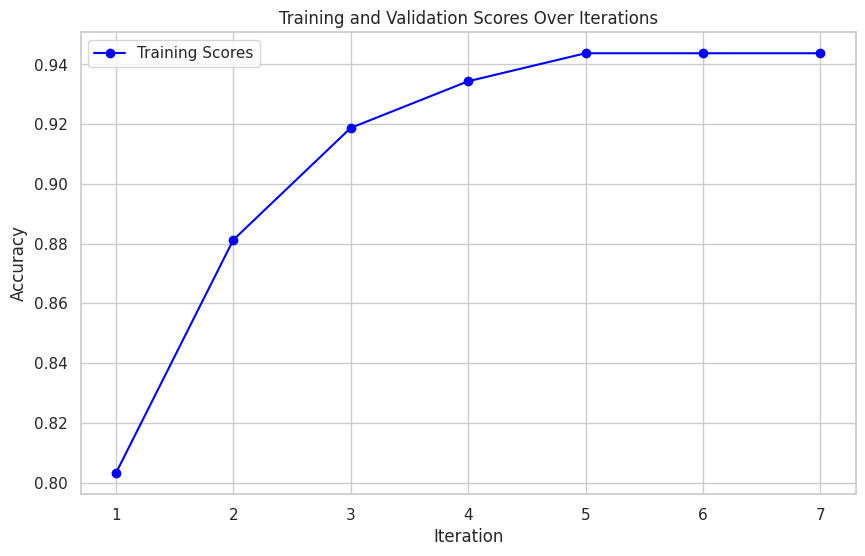

In [12]:
# plot validation and training scores on same graph
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Set the style
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(1, len(training_scores) + 1)
ax.plot(x, training_scores, marker='o', label='Training Scores', color='blue')
# ax.plot(x, validation_scores, marker='o', label='Validation Scores', color='orange')

ax.set_xlabel('Iteration')
ax.set_ylabel('Accuracy')
ax.set_title('Training and Validation Scores Over Iterations')
ax.legend()
plt.show()


# biomedCLIP ensemble prompts

In [36]:
# Example usage of the new function
evaluate_ensemble_prompts(pq, 1, validation_loader)
evaluate_ensemble_prompts(pq, 5, validation_loader)
evaluate_ensemble_prompts(pq, 10, validation_loader)
evaluate_ensemble_prompts(pq, 20, validation_loader)
# evaluation_results = evaluate_ensemble_prompts(pq, 10, test_loader)

# You can access the results like:
# print(evaluation_results['accuracy'])
# print(evaluation_results['auc'])
# print(evaluation_results['cm'])
# print(evaluation_results['report'])

Evaluating with Ensemble Prompts: 100%|██████████| 4/4 [00:03<00:00,  1.08it/s]



Test Accuracy (Ensemble):     0.8000
ROC AUC (Ensemble):           0.9008

Confusion Matrix (Ensemble):
[[49  2]
 [18 31]]

Classification Report (Ensemble):
              precision    recall  f1-score   support

   non-tumor     0.7313    0.9608    0.8305        51
       tumor     0.9394    0.6327    0.7561        49

    accuracy                         0.8000       100
   macro avg     0.8354    0.7967    0.7933       100
weighted avg     0.8333    0.8000    0.7940       100



Evaluating with Ensemble Prompts: 100%|██████████| 4/4 [00:03<00:00,  1.11it/s]



Test Accuracy (Ensemble):     0.8500
ROC AUC (Ensemble):           0.9112

Confusion Matrix (Ensemble):
[[49  2]
 [13 36]]

Classification Report (Ensemble):
              precision    recall  f1-score   support

   non-tumor     0.7903    0.9608    0.8673        51
       tumor     0.9474    0.7347    0.8276        49

    accuracy                         0.8500       100
   macro avg     0.8688    0.8477    0.8474       100
weighted avg     0.8673    0.8500    0.8478       100



Evaluating with Ensemble Prompts: 100%|██████████| 4/4 [00:03<00:00,  1.11it/s]



Test Accuracy (Ensemble):     0.8500
ROC AUC (Ensemble):           0.9044

Confusion Matrix (Ensemble):
[[49  2]
 [13 36]]

Classification Report (Ensemble):
              precision    recall  f1-score   support

   non-tumor     0.7903    0.9608    0.8673        51
       tumor     0.9474    0.7347    0.8276        49

    accuracy                         0.8500       100
   macro avg     0.8688    0.8477    0.8474       100
weighted avg     0.8673    0.8500    0.8478       100



Evaluating with Ensemble Prompts: 100%|██████████| 4/4 [00:03<00:00,  1.09it/s]


Test Accuracy (Ensemble):     0.8400
ROC AUC (Ensemble):           0.9064

Confusion Matrix (Ensemble):
[[48  3]
 [13 36]]

Classification Report (Ensemble):
              precision    recall  f1-score   support

   non-tumor     0.7869    0.9412    0.8571        51
       tumor     0.9231    0.7347    0.8182        49

    accuracy                         0.8400       100
   macro avg     0.8550    0.8379    0.8377       100
weighted avg     0.8536    0.8400    0.8381       100



{'accuracy': 0.84,
 'auc': np.float64(0.9063625450180072),
 'cm': array([[48,  3],
        [13, 36]]),
 'report': '              precision    recall  f1-score   support\n\n   non-tumor     0.7869    0.9412    0.8571        51\n       tumor     0.9231    0.7347    0.8182        49\n\n    accuracy                         0.8400       100\n   macro avg     0.8550    0.8379    0.8377       100\nweighted avg     0.8536    0.8400    0.8381       100\n'}